# Capstone Project 24.1: Final Report

# 1. Introduction

This notebook explores a dataset of TripAdvisor hotel reviews, where each review is coupled with a user-provided rating on a 1-to-5 scale. The textual content of the reviews serves as the primary predictor variable, while the numerical rating (1 being highly negative and 5 being highly positive) acts as the target. Our objective is to develop a machine learning model that predicts the rating from the review text, and to derive insights into the sentiments and characteristics that shape these ratings.

We begin by preprocessing the text data—removing unnecessary words, normalizing, and tokenizing to ensure a clean, meaningful feature set. TF-IDF (Term Frequency–Inverse Document Frequency) is then applied to convert the processed text into numerical vectors suitable for machine learning algorithms. Recognizing that rating classes may be imbalanced, we use oversampling strategies like ADASYN to create a more balanced training distribution.

Multiple models, including Naive Bayes, Logistic Regression, Random Forest, and Support Vector Machines (SVM), are trained and fine-tuned through GridSearchCV. Their performance is evaluated using accuracy, precision, recall, and F1-score. Synthetic test reviews, representing good, neutral, and bad experiences, are also introduced to validate that the final model’s predictions align with real-world expectations.

The outcomes of this analysis can support hospitality businesses by automating review sentiment analysis, highlighting common customer issues, and using these insights to enhance services. By the end of this notebook, we aim to provide a robust predictive model and actionable recommendations for understanding and improving guest satisfaction.

### ChatGPT o1 was used to create code for this project.

# 2. Importing Libraries and Preparing the Environment

This section of the code sets up the environment for performing data preprocessing, natural language processing (NLP), machine learning, and visualization. Below is a breakdown of the key components:

In [1]:
# Standard Library Imports
import pkg_resources
import re
import time
from collections import Counter

# Numerical and Data Manipulation Libraries
import numpy as np
import pandas as pd

# Parallel Processing Libraries
from pandarallel import pandarallel

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing Libraries
import nltk
import pycountry
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from textblob import TextBlob

# Machine Learning and Preprocessing Libraries
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

# Core Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Additional Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Imbalanced Learning Utilities
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Other Utilities
from joblib import dump

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('data/tripadvisor_hotel_reviews.csv')


[nltk_data] Downloading package punkt to /home/mark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3. Initial Data Exploration, Understanding the Data

In this section, several commands are used to quickly understand the dataset:

- df.head(): Displays the first few rows of the DataFrame.
- df.describe(): Shows summary statistics for numerical columns (mean, std, min, max, quartiles).
- df.info(): Provides data types, non-null counts, and memory usage, helping identify missing values and data structure.
- df.shape: Returns the number of rows and columns in the DataFrame.
- df.columns: Lists all column names, giving an overview of available features.
- df.isnull().sum(): Shows how many missing values each column contains, highlighting data completeness issues.

In [2]:
df.head()  

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
df.describe() 

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
df.shape 

(20491, 2)

In [6]:
df.columns 

Index(['Review', 'Rating'], dtype='object')

In [7]:
df.isnull().sum() 

Review    0
Rating    0
dtype: int64

## 5 Adjusting the Rating scale

This code (currently commented out) demonstrates how to modify the original 5-level rating system into a 3-level scale by mapping ratings of 4 to 5 and ratings of 2 to 1. Running df.head() afterward allows for a quick check of the updated ratings in the DataFrame’s first few rows.
This manipulation of the Rating increases the accuracy of some of the models.

In [8]:
# Replace 4 with 5 and 2 with 1 in the 'Rating' column
#df['Rating'] = df['Rating'].replace({4: 5, 2: 1})
#df.head()  # Display first few rows of data

# 5. Outlier Removal

This section of the code is focused on identifying and removing outliers from the dataset based on the length of the reviews. Here's what each line does:

In [9]:
# Outlier Removal
df['word_count'] = df['Review'].str.split().apply(len)
df['text_length'] = df['Review'].str.len()

# Removing reviews with outliers based on text length and word count (e.g., reviews longer than 95th percentile)
word_count_threshold = df['word_count'].quantile(0.95)
df = df[df['word_count'] <= word_count_threshold]

# Display the first few rows after outlier removal
df.head()


,Review,Rating,word_count,text_length
0,nice hotel expensive parking got good deal sta...,4,87,593
1,ok nothing special charge diamond member hilto...,2,250,1689
2,nice rooms not 4* experience hotel monaco seat...,3,217,1427
3,"unique, great stay, wonderful time hotel monac...",5,89,600
4,"great stay great stay, went seahawk game aweso...",5,191,1281


# 6. Visualizing Review Word Count, Text Length, and Rating Distributions

This section of the code is focused on visualizing key characteristics of the dataset, including the distribution of review word counts, text lengths, and ratings. It uses matplotlib and seaborn for creating the plots.

A key finding here is that this is not a balanced dataset.

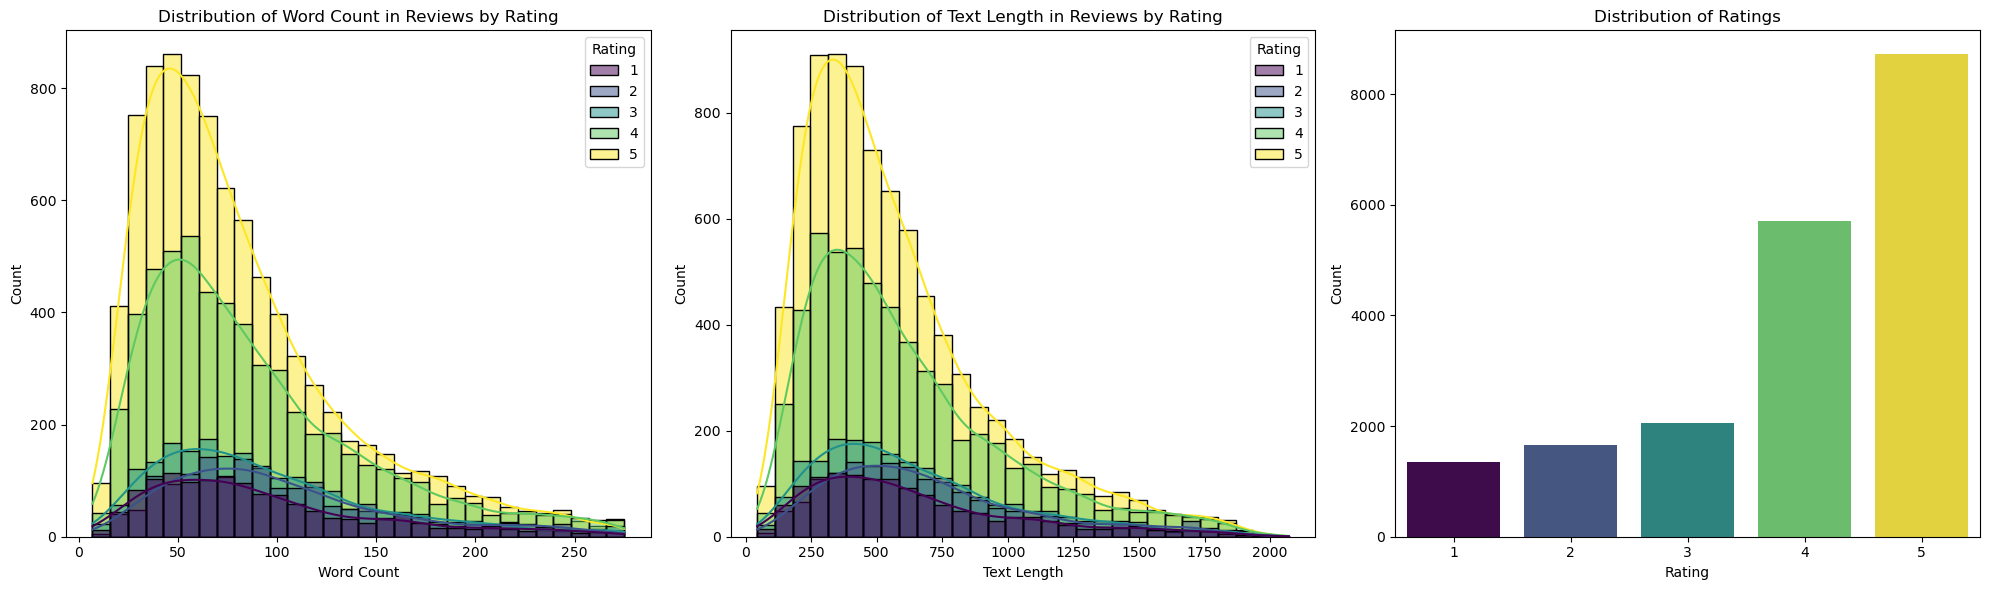

In [10]:
# Review Word Count, Text Length, and Rating Distributions

def plot_review_distributions(df):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    sns.histplot(
        df, x='word_count', bins=30, ax=axes[0], kde=True, hue='Rating', palette='viridis'
    )
    axes[0].set_title('Distribution of Word Count in Reviews by Rating')
    axes[0].set_xlabel('Word Count')
    
    sns.histplot(
        df, x='text_length', bins=30, ax=axes[1], kde=True, hue='Rating', palette='viridis'
    )
    axes[1].set_title('Distribution of Text Length in Reviews by Rating')
    axes[1].set_xlabel('Text Length')
    
    # Modify the countplot
    sns.countplot(
        data=df, x='Rating', hue='Rating', palette='viridis', ax=axes[2]
    )
    axes[2].set_title('Distribution of Ratings')
    axes[2].set_xlabel('Rating')
    axes[2].set_ylabel('Count')
    
    # Remove the legend as it's redundant
    axes[2].legend_.remove()
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize word count, text length, and rating distributions
plot_review_distributions(df)

# 7. Spell Checking and Parallel Processing

This code uses SymSpell to correct spelling in reviews and stores the corrected text in a new column. By toggling `apply_spell_check` between `True` and `False`, we can easily turn the spell correction on or off and later compare its impact on model accuracy.

In [12]:
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Add custom words
custom_words = ['tripadvisor', 'wifi', 'lobby', 'spa', 'concierge', 'cozy'
                #,'1*','2*','3*','4*','5*'
               ]
for word in custom_words:
    sym_spell.create_dictionary_entry(word, 1)

# Define spell-check function
def spell_check_review(review):
    suggestions = sym_spell.lookup_compound(review, max_edit_distance=2)
    if suggestions:
        corrected_review = suggestions[0].term
    else:
        corrected_review = review
    return corrected_review

apply_spell_check = True  # Set True to enable spell checking, False to disable

if apply_spell_check:
    df['corrected_review'] = df['Review'].parallel_apply(spell_check_review)
else:
    df['corrected_review'] = df['Review']  # No correction applied

# Verify the results
print(df[['Review', 'corrected_review']].head(10))

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


                                              Review  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   
5  love monaco staff husband stayed hotel crazy w...   
6  cozy stay rainy city, husband spent 7 nights m...   
7  excellent staff, housekeeping quality hotel ch...   
8  hotel stayed hotel monaco cruise, rooms genero...   
9  excellent stayed hotel monaco past w/e delight...   

                                    corrected_review  
0  nice hotel expensive parking got good deal sta...  
1  of nothing special charge diamond member hilto...  
2  nice rooms not a experience hotel monaco seatt...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay went sea hawk game aweso...  
5  love monaco staff husband stayed hotel crazy w... 

In [13]:
df.head(10)

,Review,Rating,word_count,text_length,corrected_review
0,nice hotel expensive parking got good deal sta...,4,87,593,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,250,1689,of nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,217,1427,nice rooms not a experience hotel monaco seatt...
3,"unique, great stay, wonderful time hotel monac...",5,89,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,191,1281,great stay great stay went sea hawk game aweso...
5,love monaco staff husband stayed hotel crazy w...,5,134,1002,love monaco staff husband stayed hotel crazy w...
6,"cozy stay rainy city, husband spent 7 nights m...",5,101,748,cozy stay rainy city husband spent a nights mo...
7,"excellent staff, housekeeping quality hotel ch...",4,85,597,excellent staff housekeeping quality hotel cho...
8,"hotel stayed hotel monaco cruise, rooms genero...",5,59,419,hotel stayed hotel monaco cruise rooms generou...
9,excellent stayed hotel monaco past w/e delight...,5,35,271,excellent stayed hotel monaco past we delight ...


# 8. Adding Domain-Specific Stop Words

In this section, we define and update a custom set of domain-specific stop words (stored in `domain_stop_words`) relevant to hotel reviews. By including these words, we remove terms that offer little analytic value and thus focus our text analysis on more meaningful content. 

If you wish to disable adding certain categories of domain-specific stop words (e.g., country names, hotel-related terms), you can simply comment out the corresponding update lines. This gives you flexibility in fine-tuning which additional words are treated as stop words.

In [14]:
# Add domain-specific stop words
domain_stop_words = set([])

# Get list of country names
countries = [country.name.lower() for country in pycountry.countries]

# Include common alternative names and abbreviations
additional_countries = [
    'usa', 'us', 'uk', 'united states', 'united kingdom', 'america', 'england',
    'scotland', 'wales', 'northern ireland', 'uae', 'united arab emirates',
    'south korea', 'north korea', 'czech republic', 'slovakia'
]

# Add hotel stop words

hotel_stop_words = ['stayed','good','room','hotel','night','day','stay','breakfast','restaurant','staff']

# Experiment with these hotel stop words
'''
hotel_stop_words = [
    'like', 'clean','husband','wife','went','hour','minute','great','beach','good','buffet','city','star','water','trip','resort','nt','got','hotel',
    'hotels', 'room', 'rooms', 'stay', 'stayed', 'staying', 'check-in', 'check-out','am','pm', 'really',
    'lobby', 'staff', 'service', 'services', 'reservation', 'booking', 'night', 'nights','day', 'days',
    'bed', 'beds', 'bathroom', 'bathrooms', 'floor', 'floors', 'guest', 'guests',
    'visit', 'visited', 'location', 'area', 'place', 'property', 'building', 'facilities',
    'amenities', 'reception', 'desk', 'price', 'cost', 'charge', 'charges', 'rate', 'rates',
    'manager', 'management', 'experience', 'experiences', 'time', 'times', 'parking',
    'breakfast', 'dinner', 'lunch', 'food', 'restaurant', 'restaurants', 'bar', 'bars',
    'pool', 'pools', 'spa', 'gym', 'fitness', 'internet', 'wifi', 'view', 'views',
    'air conditioning', 'ac', 'heater', 'heating', 'television', 'tv', 'phone', 'phones',
    'luggage', 'baggage', 'shower', 'towels',
    'people', 'person', 'thing', 'things', 'day', 'days', 'year', 'years', 'week', 'weeks',
    'hilton', 'marriott', 'sheraton', 'hyatt', 'holiday inn', 'best western', 'intercontinental',
    'accor', 'motel', 'inn', 'suites', 'monday','tuesday','wednesday','thursday','friday','saturday',
    'sunday','january','february','march','april','may','june','july','august','september','october',
    'november','december'
]
'''   
# List of popular holiday destinations
holiday_destinations = [
    'paris', 'london', 'new york', 'tokyo', 'dubai', 'singapore', 'barcelona',
    'rome', 'bali', 'bangkok', 'amsterdam', 'sydney', 'las vegas', 'hong kong',
    'los angeles', 'istanbul', 'milan', 'vienna', 'prague', 'miami', 'seoul',
    'san francisco', 'orlando', 'rio de janeiro', 'cape town', 'moscow',
    'beijing', 'cancun', 'dublin', 'toronto', 'florence', 'venice', 'madrid',
    'chiang mai', 'edmonton', 'montreal', 'copenhagen', 'zurich', 'geneva',
    'shanghai', 'kuala lumpur', 'seville', 'marrakech', 'santorini',
    'mykonos', 'lisbon', 'budapest', 'krakow', 'nice', 'cairo', 'jerusalem',
    'berlin', 'munich', 'brussels', 'athens', 'stockholm', 'oslo', 'helsinki',
    'auckland', 'melbourne', 'honolulu', 'philadelphia', 'atlanta', 'chicago',
    'san diego', 'seattle', 'houston', 'dallas', 'boston', 'washington dc',
    'nashville', 'new orleans', 'savannah', 'charleston', 'portland',
    'vancouver', 'mexico city', 'sao paulo', 'lima', 'bogota', 'buenos aires',
    'santiago', 'manila', 'hanoi', 'ho chi minh city', 'phuket', 'koh samui',
    'siem reap', 'macao', 'taipei', 'delhi', 'mumbai', 'jaipur', 'goa',
    'agra', 'colombo', 'male', 'doha', 'riyadh', 'amman', 'doha', 'sofia',
    'bucharest', 'belgrade', 'zagreb', 'ljubljana', 'tallinn', 'riga',
    'vilnius', 'luxembourg', 'monaco', 'andorra', 'reykjavik', 'antigua',
    'barbados', 'bahamas', 'jamaica', 'dominican republic', 'puerto vallarta',
    'cabo san lucas', 'hawaii', 'fiji', 'maldives', 'seychelles', 'mauritius'
    'seattle','amsterdam','europe','asia','schipol'
]
# List of US states and territories
us_states = [
    'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
    'connecticut', 'delaware', 'florida', 'georgia', 'hawaii', 'idaho',
    'illinois', 'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine',
    'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi',
    'missouri', 'montana', 'nebraska', 'nevada', 'new hampshire', 'new jersey',
    'new mexico', 'new york', 'north carolina', 'north dakota', 'ohio',
    'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina',
    'south dakota', 'tennessee', 'texas', 'utah', 'vermont', 'virginia',
    'washington', 'west virginia', 'wisconsin', 'wyoming',
    # Territories
    'puerto rico', 'guam', 'american samoa', 'u.s. virgin islands', 'northern mariana islands'
]

# Common abbreviations
us_states_abbreviations = [
    'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id',
    'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms',
    'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok',
    'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv',
    'wi', 'wy',
    # Territories abbreviations
    'pr', 'gu', 'as', 'vi', 'mp'
]

# Update domain_stop_words with all new terms, comment out lines if needed
domain_stop_words.update(countries)
domain_stop_words.update(additional_countries)
domain_stop_words.update(hotel_stop_words)
domain_stop_words.update(holiday_destinations)
domain_stop_words.update(us_states)
domain_stop_words.update(us_states_abbreviations)

# 9. Text Preprocessing and Analyzing Top Words for Each Rating

This section of the code performs text preprocessing on hotel reviews and identifies the most common words for each rating. 

Why This Step is Important

- Text Preprocessing:
Ensures the data is clean and consistent for analysis or modeling.
Removes irrelevant words (stop words) and standardizes word forms (lemmatization).

- Exploratory Analysis:
Identifying top words for each rating provides insights into the language used in positive and negative reviews.
Can reveal common themes (e.g., "clean," "friendly" for high ratings; "dirty," "rude" for low ratings).

- Feature Engineering:
The top words can be used as features in machine learning models to predict ratings.
Helps focus on words that are most indicative of user sentiment.

In [15]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define standard stop words
stop_words = set(stopwords.words('english'))

# Combine all stop words
all_stop_words = stop_words.union(domain_stop_words)

def preprocess_text(text):
    if not isinstance(text, str):
        return "", []  # Handle non-string inputs gracefully

    # Normalize text
    text = text.lower()
    text = text.replace('*', 'star')  # Replace asterisks with 'star'
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word not in all_stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin tokens into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text, tokens  # Return both preprocessed text and tokens

# Apply preprocessing to the 'corrected_review' column and assign to 'cleaned_review' and 'tokens'
df[['cleaned_review', 'tokens']] = df['corrected_review'].apply(
    lambda x: pd.Series(preprocess_text(x))
)

# Verify the assignment
print(df[['cleaned_review', 'tokens']].head())

# Display the top words in each rating after preprocessing
top_words_per_rating = {}

# Loop through each unique rating in the DataFrame
for rating in sorted(df['Rating'].unique()):
    # Subset the DataFrame to include only reviews with the current rating
    df_rating = df[df['Rating'] == rating]

    # Combine all tokens in this rating into a single list
    tokens = [token for tokens_list in df_rating['tokens'] for token in tokens_list]

    # Count word frequencies using Counter
    word_counts = Counter(tokens)

    # Get the top 20 most common words and their counts
    top_words = word_counts.most_common(20)

    # Store the results in the dictionary
    top_words_per_rating[rating] = top_words


                                      cleaned_review  \
0  expensive parking got deal anniversary arrived...   
1  nothing special charge diamond member hilton d...   
2  room experience level positive large bathroom ...   
3  unique great wonderful time location excellent...   
4  great great went sea hawk game awesome downfal...   

                                              tokens  
0  [expensive, parking, got, deal, anniversary, a...  
1  [nothing, special, charge, diamond, member, hi...  
2  [room, experience, level, positive, large, bat...  
3  [unique, great, wonderful, time, location, exc...  
4  [great, great, went, sea, hawk, game, awesome,...  


In [16]:
df

,Review,Rating,word_count,text_length,corrected_review,cleaned_review,tokens
0,nice hotel expensive parking got good deal sta...,4,87,593,nice hotel expensive parking got good deal sta...,expensive parking got deal anniversary arrived...,"[expensive, parking, got, deal, anniversary, a..."
1,ok nothing special charge diamond member hilto...,2,250,1689,of nothing special charge diamond member hilto...,nothing special charge diamond member hilton d...,"[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,217,1427,nice rooms not a experience hotel monaco seatt...,room experience level positive large bathroom ...,"[room, experience, level, positive, large, bat..."
3,"unique, great stay, wonderful time hotel monac...",5,89,600,unique great stay wonderful time hotel monaco ...,unique great wonderful time location excellent...,"[unique, great, wonderful, time, location, exc..."
4,"great stay great stay, went seahawk game aweso...",5,191,1281,great stay great stay went sea hawk game aweso...,great great went sea hawk game awesome downfal...,"[great, great, went, sea, hawk, game, awesome,..."
...,...,...,...,...,...,...,...
20485,not impressed unfriendly staff checked asked h...,2,87,616,not impressed unfriendly staff checked asked h...,impressed unfriendly checked asked higher floo...,"[impressed, unfriendly, checked, asked, higher..."
20486,"best kept secret 3rd time staying charm, not 5...",5,109,733,best kept secret ord time staying charm not a ...,best kept secret ord time staying charm star c...,"[best, kept, secret, ord, time, staying, charm..."
20487,great location price view hotel great quick pl...,4,39,306,great location price view hotel great quick pl...,great location price view great quick place si...,"[great, location, price, view, great, quick, p..."
20488,"ok just looks nice modern outside, desk staff ...",2,63,443,of just looks nice modern outside desk staff n...,look modern outside desk particularly friendly...,"[look, modern, outside, desk, particularly, fr..."


### 9.1 Visualize Top Words for each Rating Category

This code creates bar charts of the top words for each rating category. For each rating:

- It converts the top words and their counts into a DataFrame.
- It plots a horizontal bar chart (using seaborn) showing the word counts.
- Each bar is annotated with its exact count.
- The plot is given a title and labels, then displayed with a neat layout.

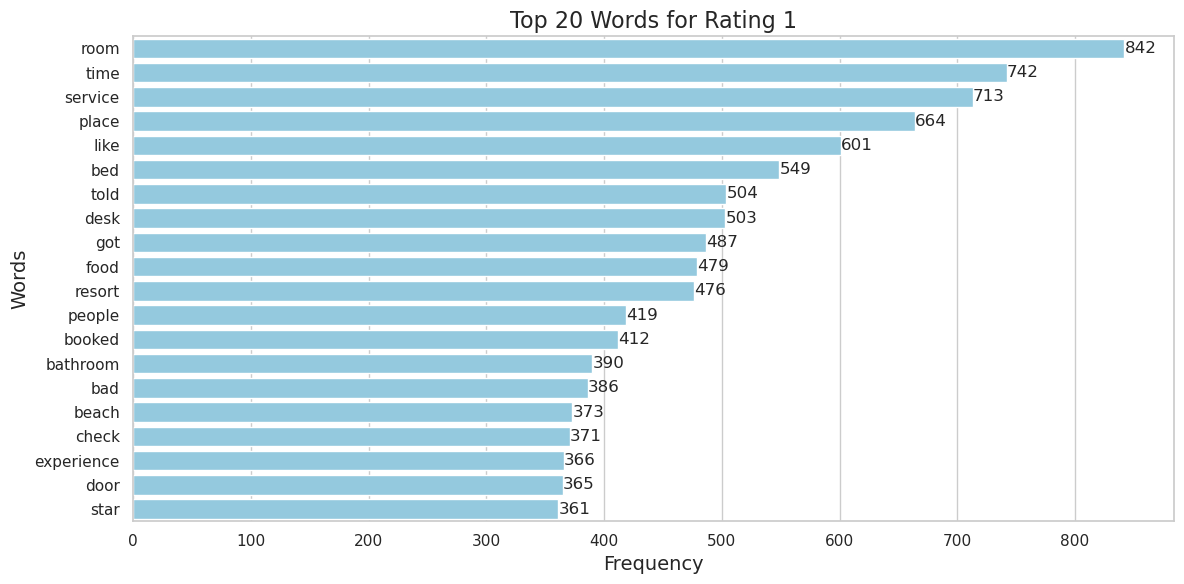

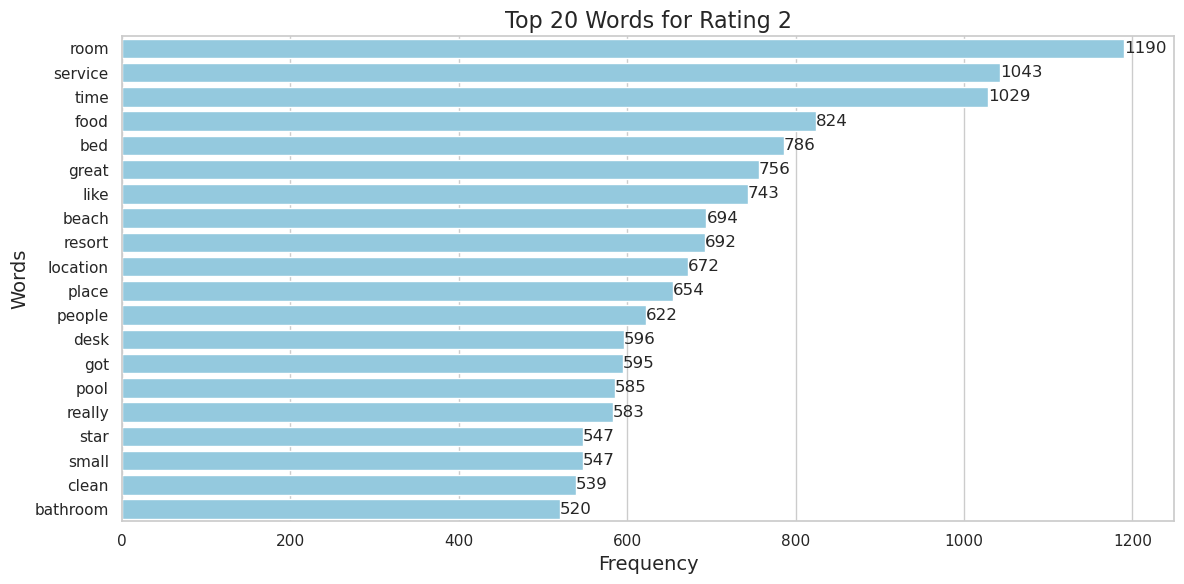

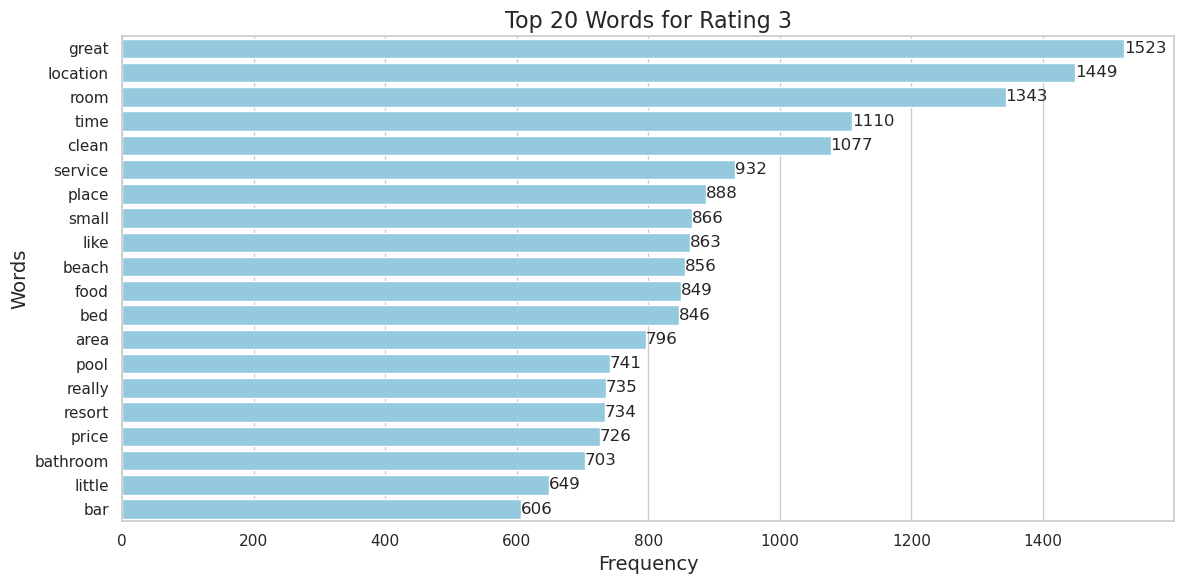

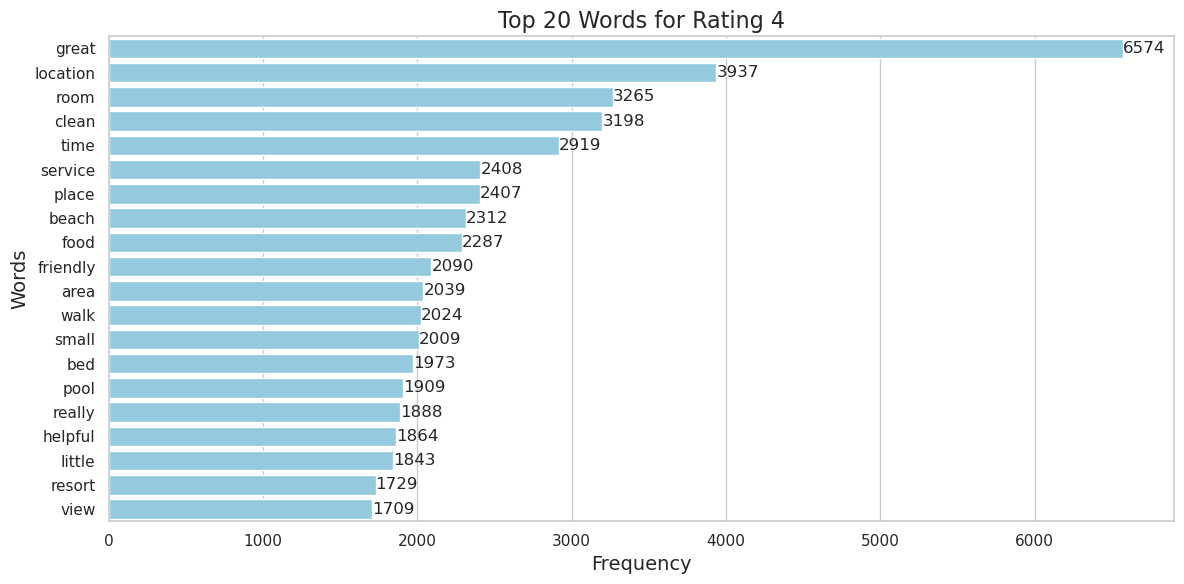

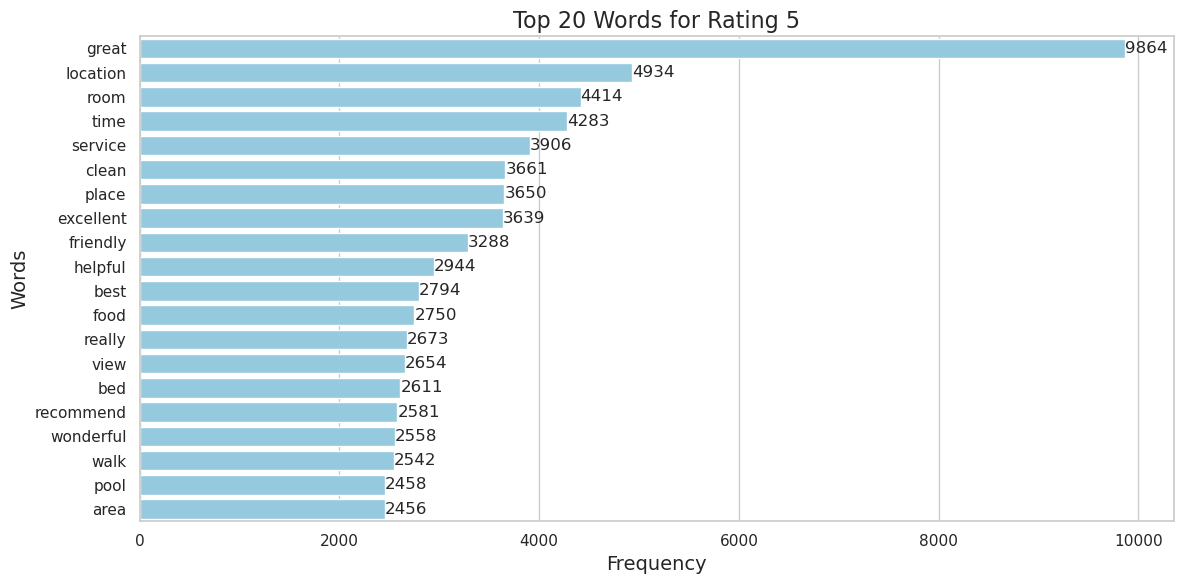

In [17]:
sns.set_theme(style="whitegrid")

# Visualization: Sorted Bar Charts with Data Labels
for rating, words in top_words_per_rating.items():
    words_df = pd.DataFrame(words, columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Count', y='Word', data=words_df, color='skyblue')
    plt.title(f'Top 20 Words for Rating {rating}', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    
    # Add data labels
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.0f'),
                    (p.get_width()+0.1, p.get_y() + p.get_height()/2.),
                    ha='left', va='center')
    
    plt.tight_layout()
    plt.show()


# 10. Preparing Data for Modeling

This step prepares the dataset for machine learning by separating the input features (independent variables) from the target variable (dependent variable).

In [18]:
# Prepare data for modeling
X = df['cleaned_review']
y = df['Rating']

# 11. Feature Engineering

This code checks whether use_numeric_features is enabled. If it is (True), it sets numeric_cols to include ['word_count', 'text_length']. If it’s disabled (False), it leaves numeric_cols empty. In other words, it toggles between using these numeric columns or not, depending on the user’s choice.

In [19]:
use_numeric_features = True   # Set False to exclude word_count and text_length numeric features

if use_numeric_features:
    numeric_cols = ['word_count', 'text_length']
else:
    numeric_cols = []  # No numeric features

# 12. Data Splitting and TF-IDF Vectorization

This code first splits the data into training and test sets while maintaining class proportions (via stratification) and sets a fixed random_state for reproducibility. It then initializes a TF-IDF vectorizer with a maximum of 10,000 features and a minimum document frequency of 2, ensuring a manageable, informative numeric representation of the text data for the modeling process.

In [20]:
random_state = 42

# Split Data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state, stratify=y
)

# set up a TF-IDF vectorizer to produce a manageable, meaningful numeric feature representation from text data.
text_transformer = TfidfVectorizer(max_features=10000, min_df=2)

# 13. Preprocessing and Feature Transformation

This code creates a column transformer that applies TF-IDF vectorization to the 'cleaned_review' column and passes any numeric columns through unchanged. All other columns are dropped. It ensures the text and numeric features are properly combined into a single feature matrix for modeling.

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'cleaned_review'),
        ('numeric', 'passthrough', numeric_cols)  # Will output numeric features as-is
    ],
    remainder='drop'
)

# 14. Defining the Candidate Models

This code creates a dictionary mapping model names to their corresponding default classifier instances. Models can be commented out (like SVM and Gradient Boosting) which will be excluded from the current training run due to time contraints

In [22]:
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
    'Random Forest': RandomForestClassifier(random_state=random_state),
    'K-Nearest Neighbors': KNeighborsClassifier(),
   # 'SVM': SVC(probability=True, random_state=random_state),
   # 'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
}

# 15. Building the Pipeline Template

This code sets up a pipeline template that preprocesses text data, optionally applies scaling and oversampling, and then fits a default model (Naive Bayes). The actual scaler, oversampler, and model can be overridden later through hyperparameter tuning.

In [23]:
pipeline_template = ImbPipeline([
    ('preprocessor', preprocessor),
    ('scaler', 'passthrough'),     # Default: no scaling
    ('oversampler', 'passthrough'),# Default: no oversampling
    ('model', MultinomialNB())     # Default model: Naive Bayes (will be overridden in each grid)
])

# 16. Defining the Hyperparameter Search Space

This code defines the hyperparameter search spaces (parameter grids) for multiple machine learning models. Each entry specifies which model, parameters, and transformations (scaler, oversampler) will be tested during GridSearchCV, allowing for systematic tuning and optimization.

In [24]:
param_grids = {
    'Naive Bayes': {
        'model': [MultinomialNB()],
        'model__alpha': [0.1, 0.5, 1.0],
        'scaler': ['passthrough', MaxAbsScaler()],  
        'oversampler': ['passthrough', SMOTE(random_state=random_state), ADASYN(random_state=random_state)]
    },
    'Logistic Regression': {
        'model': [LogisticRegression(solver='saga', max_iter=10000, random_state=random_state)],
        'model__C': [0.01, 0.1, 1.0],
        'scaler': ['passthrough', MaxAbsScaler()],
        'oversampler': ['passthrough', SMOTE(random_state=random_state)]
    },
    'Random Forest': {
        'model': [RandomForestClassifier(random_state=random_state)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10],
        'scaler': ['passthrough', MaxAbsScaler()],
        'oversampler': ['passthrough', ADASYN(random_state=random_state)]
    },
    'K-Nearest Neighbors': {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5],
        'scaler': ['passthrough', MaxAbsScaler()],
        'oversampler': ['passthrough', SMOTE(random_state=random_state), ADASYN(random_state=random_state)]
    },    
    'SVM': {
        'model': [SVC(random_state=random_state, probability=True)],
        'model__C': [0.1, 1.0, 10.0],
        'model__kernel': ['linear', 'rbf'],
        'oversampler': ['passthrough', SMOTE(random_state=random_state), ADASYN(random_state=random_state)],
        'scaler': ['passthrough', MaxAbsScaler()]
    },
    'Gradient Boosting': {
        'model': [GradientBoostingClassifier(random_state=random_state)],
        'model__n_estimators': [100, 200],           
        'model__learning_rate': [0.1, 0.05],         
        'model__max_depth': [3, 5],                  
        'scaler': ['passthrough', MaxAbsScaler()],  
        'oversampler': ['passthrough', SMOTE(random_state=random_state), ADASYN(random_state=random_state)]
    }
}

# 17. Model Training, Hyperparameter Tuning, and Evaluation

This code iterates through each model, performing a grid search to find optimal hyperparameters, training the best model, and evaluating it on the test set. It stores performance results and best hyperparameters, prints classification reports, and optionally displays sample predicted probabilities for models that support predict_proba.

In [25]:
results = []
best_models = {}

results = []
best_models = {}

for model_name, model_to_train in models.items():
    print(f"\nTraining {model_name}...")

    # Create a GridSearchCV using the pipeline template and the model-specific param grid
    grid_search = GridSearchCV(
        estimator=pipeline_template,
        param_grid=param_grids[model_name],
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1
    )

    # Prepare training and testing DataFrames
    train_df = pd.DataFrame({'cleaned_review': X_train_text})
    if use_numeric_features:
        train_df['word_count'] = df.loc[X_train_text.index, 'word_count'].values
        train_df['text_length'] = df.loc[X_train_text.index, 'text_length'].values

    test_df = pd.DataFrame({'cleaned_review': X_test_text})
    if use_numeric_features:
        test_df['word_count'] = df.loc[X_test_text.index, 'word_count'].values
        test_df['text_length'] = df.loc[X_test_text.index, 'text_length'].values

    start_time = time.time()
    grid_search.fit(train_df, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time

    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    print(f"Time taken for {model_name}: {elapsed_time:.2f} seconds")

    # Evaluate on test set
    y_pred = best_model.predict(test_df)
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Time (s)': elapsed_time,
        'Best Hyperparameters': grid_search.best_params_
    })

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

    # If the final model supports predict_proba, print some sample probabilities
    if hasattr(best_model, 'predict_proba'):
        y_proba = best_model.predict_proba(test_df)
        print(f"Sample predicted probabilities for {model_name}:")
        print(y_proba[:10])  # print first 10 predicted probabilities
        print("-" * 50)


Training Naive Bayes...
Time taken for Naive Bayes: 14.99 seconds
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           1       0.59      0.56      0.58       403
           2       0.33      0.40      0.36       498
           3       0.31      0.34      0.33       616
           4       0.46      0.49      0.48      1710
           5       0.75      0.67      0.71      2615

    accuracy                           0.55      5842
   macro avg       0.49      0.49      0.49      5842
weighted avg       0.57      0.55      0.56      5842

--------------------------------------------------
Sample predicted probabilities for Naive Bayes:
[[0.09626068 0.51344156 0.04845995 0.22942684 0.11241097]
 [0.21190353 0.60086639 0.11346703 0.05807052 0.01569254]
 [0.17391532 0.10461889 0.08837479 0.41582249 0.21726852]
 [0.01588586 0.28711195 0.16342963 0.39887786 0.13469469]
 [0.11188403 0.29447669 0.26058886 0.25146624 0.08158418]
 [0.00267568 0.1

## 17.1 Display Results

In [26]:
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
print("\nModel Comparison:")
# Extract the dictionary into separate columns
hyperparams = results_df['Best Hyperparameters'].apply(pd.Series)
combined_df = pd.concat([results_df.drop('Best Hyperparameters', axis=1), hyperparams], axis=1)
display(combined_df)


Model Comparison:
                 Model  Accuracy    Time (s)  \
0          Naive Bayes  0.554947   14.989442   
1  Logistic Regression  0.592776  854.818252   
2        Random Forest  0.563163  296.079400   
3  K-Nearest Neighbors  0.363745   23.028485   

                                                                                                                                                        Best Hyperparameters  
0                                                            {'model': MultinomialNB(), 'model__alpha': 0.1, 'oversampler': SMOTE(random_state=42), 'scaler': 'passthrough'}  
1            {'model': LogisticRegression(max_iter=10000, random_state=42, solver='saga'), 'model__C': 0.1, 'oversampler': SMOTE(random_state=42), 'scaler': MaxAbsScaler()}  
2  {'model': RandomForestClassifier(random_state=42), 'model__max_depth': None, 'model__n_estimators': 200, 'oversampler': ADASYN(random_state=42), 'scaler': 'passthrough'}  
3                                       

# 18. Predicting Ratings for Synthetic Reviews

This section evaluates the trained machine learning models by predicting ratings for manually created synthetic reviews. These reviews represent common examples of good, neutral, and bad customer experiences.

In [28]:
# Synthetic Reviews
synthetic_reviews = {
    'Good Review': 'The hotel was amazing, everything was perfect, great location, clean rooms, and friendly staff!',
    'Neutral Review': 'The hotel was okay, nothing special, the room was clean but could be better.',
    'Bad Review': 'The hotel was terrible, the room was dirty, staff was rude, and I had a horrible experience.'
}

for model_name, model in best_models.items():
    print(f"\nPredictions from {model_name}:")
    for review_type, review_text in synthetic_reviews.items():
        # Preprocess if needed
        preprocessed_review, tokens = preprocess_text(review_text)

        # Create a DataFrame with the same structure as training input
        input_df = pd.DataFrame({'cleaned_review': [preprocessed_review]})

        # If numeric features were used during training, add them here
        if use_numeric_features:
            input_df['word_count'] = len(preprocessed_review.split())
            input_df['text_length'] = len(preprocessed_review)

        # Now predict using the pipeline model
        prediction = model.predict(input_df)

        print(f"Review: {preprocessed_review}")
        print(f"{review_type}: Predicted Rating = {prediction[0]}")
    print("-" * 50)


Predictions from Naive Bayes:
Review: amazing everything perfect great location clean room friendly
Good Review: Predicted Rating = 5
Review: okay nothing special clean could better
Neutral Review: Predicted Rating = 3
Review: terrible dirty rude horrible experience
Bad Review: Predicted Rating = 1
--------------------------------------------------

Predictions from Logistic Regression:
Review: amazing everything perfect great location clean room friendly
Good Review: Predicted Rating = 5
Review: okay nothing special clean could better
Neutral Review: Predicted Rating = 2
Review: terrible dirty rude horrible experience
Bad Review: Predicted Rating = 1
--------------------------------------------------

Predictions from Random Forest:
Review: amazing everything perfect great location clean room friendly
Good Review: Predicted Rating = 5
Review: okay nothing special clean could better
Neutral Review: Predicted Rating = 4
Review: terrible dirty rude horrible experience
Bad Review: Predic

# 19. Model Saving Script

This code saves the trained machine learning models, along with the TF-IDF vectorizer and scaler, using joblib:

In [29]:
# Save models (which are pipelines)
for model_name, model in best_models.items():
    filename = f"{model_name.replace(' ', '_').lower()}_model.joblib"
    dump(model, filename)
    print(f"Model {model_name} saved as {filename}")

Model Naive Bayes saved as naive_bayes_model.joblib
Model Logistic Regression saved as logistic_regression_model.joblib
Model Random Forest saved as random_forest_model.joblib
Model K-Nearest Neighbors saved as k-nearest_neighbors_model.joblib


# 20. Feature Importance Analysis with Permutation Importance

This code computes permutation importance for each trained model to determine which features most influence the model’s predictions. It transforms the test set, calculates importances for a subset of samples, and then displays the top 20 most important features. This provides insights into which words and numeric features are driving the model’s performance.

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Loop through each trained model
for model_name, model in best_models.items():
    print(f"\nTop 20 Important Features for {model_name}:")

    # Transform the test data with the preprocessor to get the full feature space
    X_test_transformed = model['preprocessor'].transform(test_df)

    # Convert sparse matrix to dense array if needed
    if hasattr(X_test_transformed, 'toarray'):
        X_test_transformed = X_test_transformed.toarray()

    # Extract the final model from the pipeline
    final_model = model['model']

    # Compute permutation importance on the transformed (dense) data and final model
    subset_size = 1000  # adjust as needed
    result = permutation_importance(
        final_model, 
        X_test_transformed[:subset_size], 
        y_test[:subset_size], 
        n_repeats=1, 
        random_state=42,
        n_jobs=-1
    )
    importances = result.importances_mean

    # Extract TF-IDF feature names
    text_features = model['preprocessor'].named_transformers_['text'].get_feature_names_out()

    # Start with text feature names
    all_feature_names = list(text_features)

    # Add numeric features if applicable
    if use_numeric_features:
        all_feature_names.extend(numeric_cols)

    # Check if lengths match now
    if len(all_feature_names) != len(importances):
        print("Error: The number of features and importances still do not match.")
        print("Check if numeric features and model parameters align.")
        continue

    # Create a DataFrame for features and their importances
    feature_importances = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    })

    # Sort by importance in descending order
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    # Display the top 20 features
    print(feature_importances.head(20))


Top 20 Important Features for Naive Bayes:
           feature  importance
10000   word_count       0.103
10001  text_length       0.082
995            bit       0.004
5882         noisy       0.004
6402    perfection       0.003
9342        unless       0.003
7003         quite       0.003
300        amazing       0.003
5194           lot       0.003
8167         smile       0.003
8178       smoking       0.003
1897   comfortable       0.003
3278        facing       0.002
6578    pleasantly       0.002
9754       wedding       0.002
3043    engagement       0.002
6641          poor       0.002
2781      downtown       0.002
2617         dirty       0.002
7120    reasonably       0.002

Top 20 Important Features for Logistic Regression:
           feature  importance
10001  text_length       0.002
10000   word_count       0.002
6663    portuguese       0.000
6664          pose       0.000
6665         posed       0.000
6666          posh       0.000
6667        posing       0.000
6668 